# OAM computations for Linear field using SFA

This jupyter notebook is to compute the OAM of a linear field SFA model with a sin$^2$ pulse.
Andrew Maxwell 11/05/2021

In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import functools
import time
from itertools import repeat
from itertools import product

mpl.rcParams['savefig.pad_inches'] = 0

In [2]:
import multiprocessing
#import ipyparallel as ipp

try:
    cpus = multiprocessing.cpu_count()
except NotImplementedError:
    cpus = 8   # arbitrary default
    
pool = multiprocessing.Pool(processes=cpus)

In [3]:
Pi = np.pi
I = complex(0.,1.)

### Dump File and Pickling

currently this is how Data may be outputted, as a pickle file, we may want to change this to JSON? However, pickle files are very compact.

In [4]:
import pickle
import os
DumpFileName = 'OAM_Lin_DataDump'

In [5]:
def saveDataDump(DataKey, Data, DumpFileName):
    '''Function saves data to file via pickling for easy access and loading'''
    Dics={"Null" : 0}
    #load full database
    if(os.path.exists(DumpFileName)):
        with open(DumpFileName,'rb') as rfp:
            Dics.update(pickle.load(rfp))
            
    #Make new dictionary of data
    OutputDataDict={DataKey : Data}
    #Append new dicitonary to all dictionarys
    Dics.update(OutputDataDict)
    #open file and dump all dicitionarys
    DataDumpFile = open(DumpFileName,'wb')
    pickle.dump(Dics, DataDumpFile)
    DataDumpFile.close()

In [6]:
def loadDataDump(DataKey, DumpFileName):
    '''Function to retrieve data from pickle dump'''
    DataDumpFile = open(DumpFileName,'rb')
    DataOut = pickle.load(DataDumpFile)[DataKey]
    DataDumpFile.close()
    return DataOut

## Import SFA Linear Pulse

Here we lad the class that compute the SFA transition amplitude.
It has three class varibles Ip, Up and omega

In [7]:
import SFALinearPulse as SFA_Lin

### Create list of pulse and target parameters

In [8]:
#Make class instance
omegaIn = 0.057
IpIn = 0.579
UpIn = 0.44
NIn = 2
CEPIn = [0, Pi/2, Pi, 3*Pi/2]
ts = Pi/omegaIn + I* Pi/(2*omegaIn)
alpha=0.

#Velocity gauge: Gauge=0 \\ Length gauge: Gauge=1
Gauge=1

enant=1
nIn=[4,4,4,4]
lIn=[2,3,2,3]
mIn=[-1,-1,1,1]
constIn=[1,1j,-1,1j]

enant=0
nIn=[4,4,4,4]
lIn=[2,3,2,3]
mIn=[1,1,-1,-1]
constIn=[1,1j,-1,1j]

#make SFA pulse instance
SP = np.array([SFA_Lin.SFALinearPulse(IpIn, UpIn, omegaIn, NIn, nIn, lIn, mIn, constIn, CEPi, Gauge) 
               for CEPi in CEPIn])
    
NPulses = len(SP)

## Test orders of magnitude

In [9]:
omegaIn = 0.057
IpIn = 0.579
UpIn = 0.44
NIn = 2
CEPIn = [0.01, Pi/2, Pi+0.01, 3*Pi/2]
#CEPIn = np.linspace(0,2*Pi, 10)
ts = Pi/omegaIn + I* Pi/(2*omegaIn)
alpha=0.

Gauge=1

l2=2
nIn=[[4,4,4,4],[4,4],[4,4]]
lIn=[[2,3,2,3],[2,3],[2,3]]
mIn=[[1,1,-1,-1],[1,1],[-1,-1]]
constIn=[[1,1j,-1,1j],[1,1j],[-1,1j]]
SP = np.array([[SFA_Lin.SFALinearPulse(IpIn, UpIn, omegaIn, NIn, n, l, m, const, CEPi, Gauge) 
               for n,l,m,const in zip(nIn,lIn,mIn,constIn)] for CEPi in CEPIn])
    
NPulses = len(SP)
Nstates = len(SP[0])

In [10]:
dp=0.025
pzList = np.arange(-1., 1., dp)
pxList = np.arange(0, 0.7, dp)
py = 0
pzGrid, pxGrid = np.meshgrid(pzList, pxList)

In [11]:
MGrids_CEP2 = np.array([[pool.starmap(SP[i][k].Mxz_List, zip(pxGrid, repeat(py), pzGrid)) for k in range(Nstates)] for i in range(0, NPulses)])

In [12]:
MGrids_CEP = np.abs(MGrids_CEP2)**2

In [13]:
MGrids_sum = np.sum(MGrids_CEP, 0)/NPulses #CEP averaged
MMaxs=[M.max() for M in MGrids_sum]

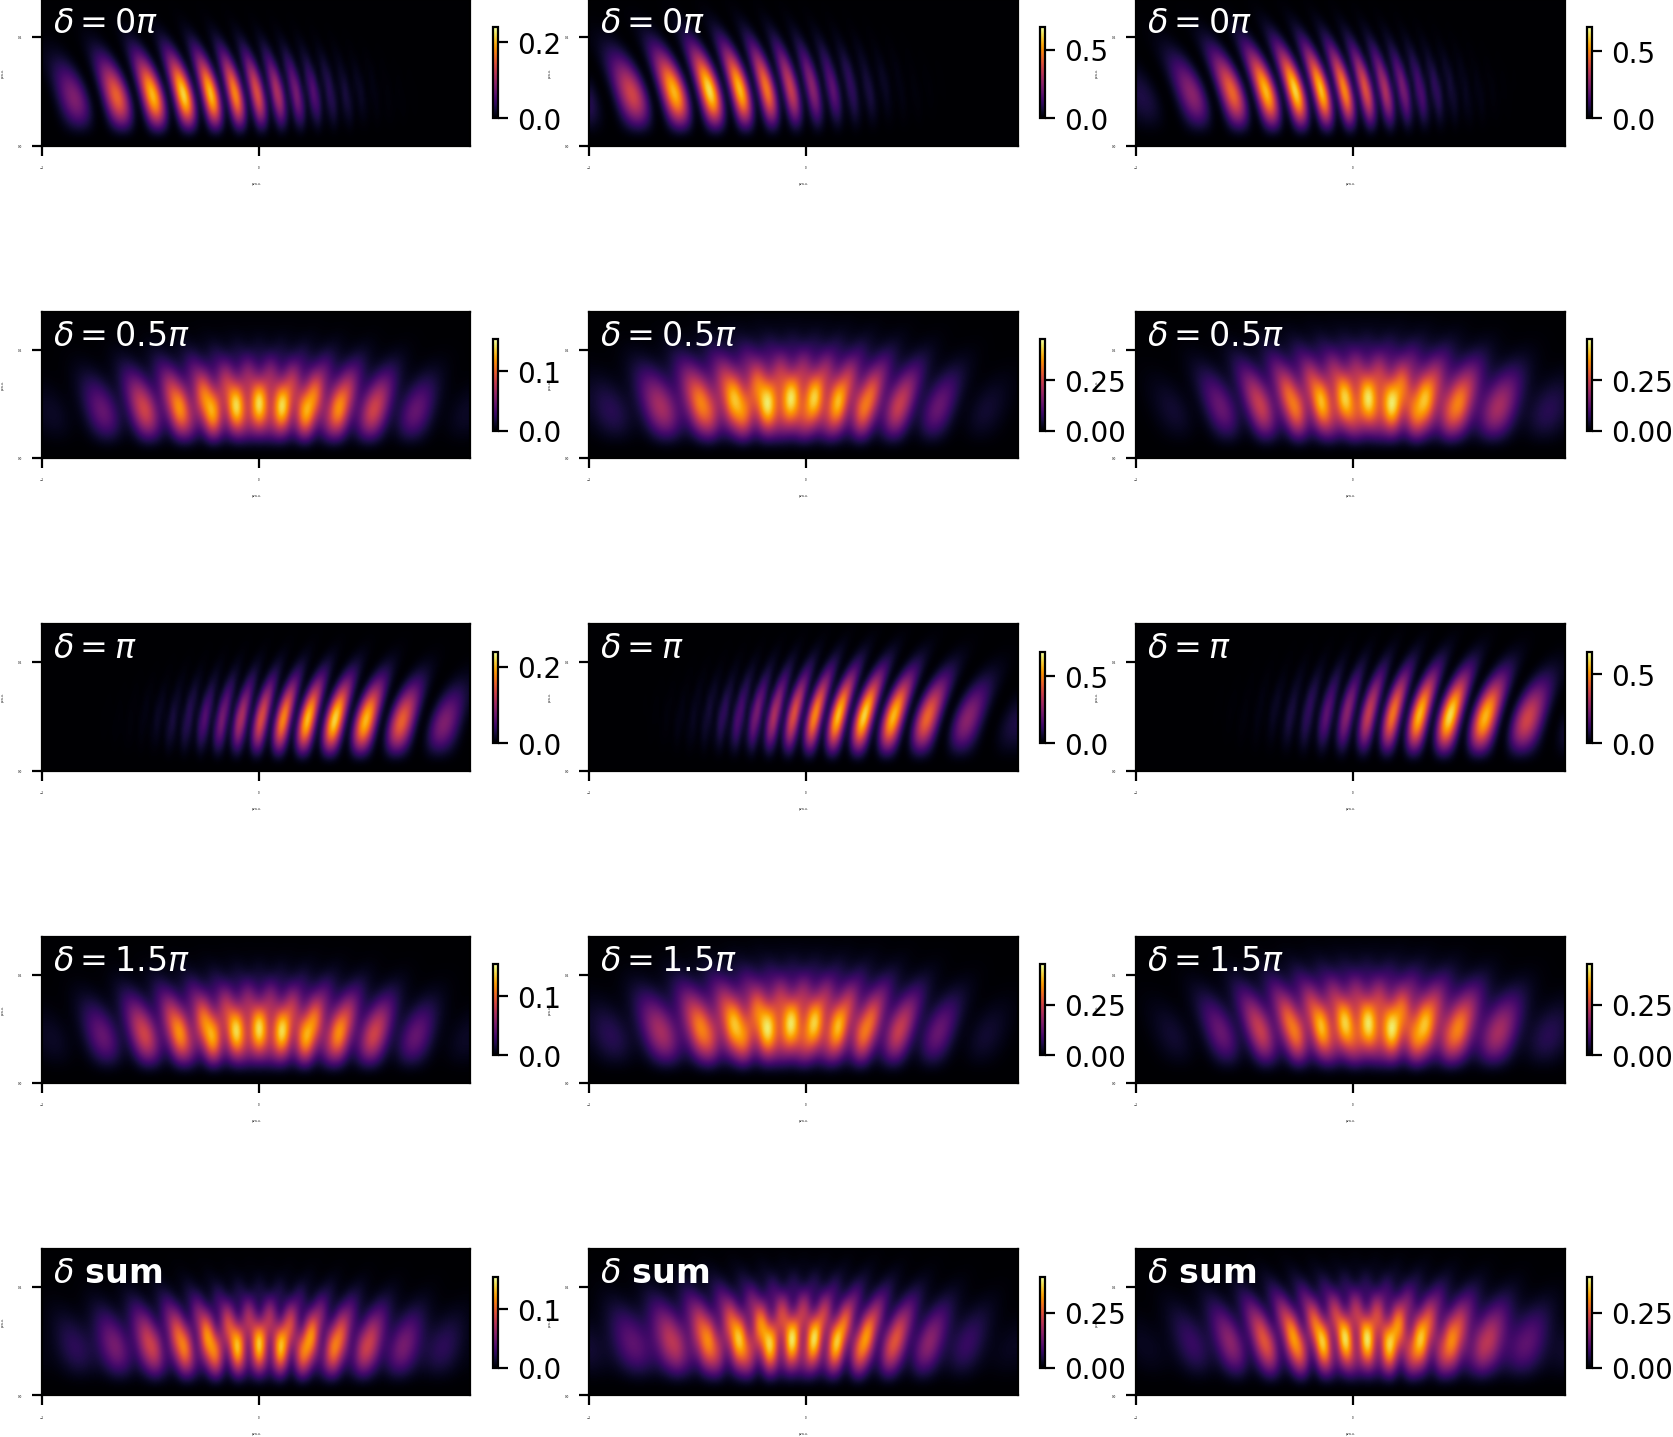

In [14]:
plt.figure(num=None, figsize=(10,10), dpi=200, facecolor='w', edgecolor='k')
plt.tight_layout()
plt.autoscale(tight=True)
panelLabels = [r"$\delta=0\pi$",r"$\delta=0.5\pi$",r"$\delta=\pi$",r"$\delta=1.5\pi$",r"$\delta$ sum"]

k=0
for i in range(0,NPulses+1):
    for j in range(0,Nstates):
        ax = plt.subplot(NPulses+1, Nstates, k+1)
        ax.tick_params(labelsize=20)
            #ax.text(0., 1.5, r"$\chi_{\rho}^{+}$, OAM="+str(OAMList[j]), transform=ax.transAxes, fontsize=15, fontweight='bold', va='top', color ='black')
            #ax.text(0., 1.3, "velocity gauge", transform=ax.transAxes, fontsize=15, fontweight='bold', va='top', color ='black')   
        plt.ylabel('$p_{x}$ a.u.', fontsize=(0))
        plt.xlabel('$p_{z}$ a.u.', fontsize=(0))
        plt.xticks(fontsize=(0))
        plt.yticks(fontsize=(0))  
        ax.text(0.025, 0.95, panelLabels[i], transform=ax.transAxes,
           fontsize=12, fontweight='bold', va='top', color ='white')
            #ax = plt.gca()
        if i<NPulses:
            im = ax.imshow(np.flip(MGrids_CEP[i][j],0), extent = (np.amin(pzList), np.amax(pzList), np.amin(pxList), np.amax(pxList)),
                        cmap=cm.inferno, #norm=LogNorm(vmin=MMaxs[j]*1e-6, vmax=MMaxs[j]), 
                        interpolation = 'bicubic')  
            plt.colorbar(im, ax=ax,fraction=0.01, pad=0.05)
        else:
            im = ax.imshow(np.flip(MGrids_sum[j],0), extent = (np.amin(pzList), np.amax(pzList), np.amin(pxList), np.amax(pxList)),
                        cmap=cm.inferno, #norm=LogNorm(vmin=MMaxs[j]*1e-6, vmax=MMaxs[j]), 
                        interpolation = 'bicubic') 
            plt.colorbar(im, ax=ax,fraction=0.01, pad=0.05)
        k=k+1
#fig.tight_layout()
#plt.savefig("X:\PHOTONICS\TFM\OAM2.jpg")

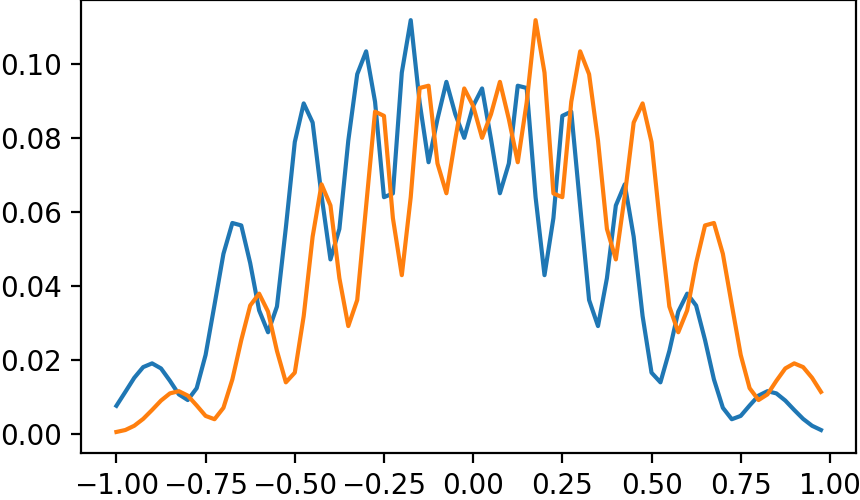

In [15]:
plt.figure(num=None, figsize=(5,3), dpi=200, facecolor='w', edgecolor='k')
iv=1
max1 = np.max(MGrids_CEP[iv][2][len(pxList)//4])
res = [ 2*(Mx-My)/(Mx+My) if (Mx+My)/2> 1e-1*max1 else np.nan for Mx, My in zip(MGrids_CEP[iv][2][len(pxList)//4],MGrids_CEP[iv][1][len(pxList)//4])]
plt.plot(pzList, MGrids_CEP[iv][1][len(pxList)//4]/Pi)
plt.plot(pzList, MGrids_CEP[iv][2][len(pxList)//4]/Pi)
#plt.plot(pzList,  res)
#plt.yscale('log')

# CEP+orientation averaging - Momentum distributions

In [16]:
dp=0.1
pzList = np.arange(-1.7, 1.7, dp)
pxList = np.arange(0, 1.7, dp)
pzGrid, pxGrid = np.meshgrid(pzList, pxList)

OAMList=[-2,2,-1,1,0]

In [17]:
SP[0][0].orientation_av_list(pxGrid[0], pzGrid[0], OAMList[0], enant)

array([4.92677399e-70, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.46702965e-65, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.45039437e-72, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

In [ ]:
MGrids_CEP = np.array([[pool.starmap(SP[i][0].orientation_av_list, zip(pxGrid, pzGrid, repeat(OAM), repeat(enant)) ) 
                     for OAM in OAMList] for i in range(0, NPulses)])
MGrids = np.sum(MGrids_CEP, 0)/NPulses #CEP averaged

In [ ]:
#OAM residual difference distributions

plt.style.use('default')
dcolours = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
#plt.subplots_adjust(left=0.25, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.2)

OAMList2=[3,2,1]

plt.figure(num=None, figsize=(10,3), dpi=200, facecolor='w', edgecolor='k')
plt.autoscale(tight=True)
plt.tight_layout()

i1=0
i2=1

for j in range(3):
    ax = plt.subplot(1, 3, 1+j)
    ax.text(0, 1.5, r"$\chi_{\rho}^{+}$, OAM=$\pm$"+str(OAMList2[j]), transform=ax.transAxes, fontsize=8, fontweight='bold', va='top', color ='black')
    ax.text(0, 1.3, "velocity gauge", transform=ax.transAxes, fontsize=8, fontweight='bold', va='top', color ='black')
    #plt.ylabel('$p_{x}$ a.u.', fontsize=(12))
    #plt.xlabel('$p_{z}$ a.u.', fontsize=(12))
    #plt.xticks(fontsize=(12))
    #plt.yticks(fontsize=(12))
    im = ax.imshow(np.flip(2*(-MGrids[i2]+MGrids[i1])/(MGrids[i2]+MGrids[i1]+1e-32),0), extent = (np.amin(pzList), np.amax(pzList), np.amin(pxList), np.amax(pxList)),
                  cmap=cm.seismic, #norm=LogNorm(vmin=MMaxs[i1]*1e-6, vmax=MMaxs[i1]), 
                    interpolation = 'bicubic', aspect = 1.)

    i1=i1+2
    i2=i2+2
    
    plt.colorbar(im, ax=ax)

plt.tight_layout()
#plt.savefig("X:\PHOTONICS\TFM\OAMdiff2.jpg")

In [ ]:
MMaxs=[np.max(MGrids[i]) for i in range(7)]

In [ ]:
#OAM distributions

plt.figure(num=None, figsize=(40, 5), dpi=200, facecolor='w', edgecolor='k')
plt.tight_layout()
plt.autoscale(tight=True)

for j in range(0,7):
    ax = plt.subplot(1,7, j+1)
    ax.tick_params(labelsize=20)
    ax.text(0., 1.5, r"$\chi_{\rho}^{+}$, OAM="+str(OAMList[j]), transform=ax.transAxes, fontsize=15, fontweight='bold', va='top', color ='black')
    ax.text(0., 1.3, "velocity gauge", transform=ax.transAxes, fontsize=15, fontweight='bold', va='top', color ='black')   
    plt.ylabel('$p_{x}$ a.u.', fontsize=(24))
    plt.xlabel('$p_{z}$ a.u.', fontsize=(24))
    plt.xticks(fontsize=(19))
    plt.yticks(fontsize=(19))   
    #ax = plt.gca()
    im = ax.imshow(np.flip(MGrids[j],0), extent = (np.amin(pzList), np.amax(pzList), np.amin(pxList), np.amax(pxList)),
              cmap=cm.inferno, #norm=LogNorm(vmin=MMaxs[j]*1e-6, vmax=MMaxs[j]), 
                interpolation = 'bicubic', aspect = 1.)  
    plt.colorbar(im, ax=ax)
    
#fig.tight_layout()
#plt.savefig("X:\PHOTONICS\TFM\OAM2.jpg")

# CEP+orientation averaging - hemisphere integrals

In [12]:
ELim = 0.5
dE = 0.03
EList = np.arange(0, ELim, dE)

OAMList = [-3,-2,-1,0,1,2,3]

MintList1_CEP = np.array([[pool.starmap(SP[i].M_integration_av, zip(EList, repeat(0.), repeat(Pi/6), repeat(OAM), repeat(1.0e-02), repeat(500), repeat(enant) )) 
                       for OAM in OAMList] for i in range(0, NPulses)])
MintList2_CEP = np.array([[pool.starmap(SP[i].M_integration_av, zip(EList, repeat(5*Pi/6), repeat(Pi), repeat(OAM), repeat(1.0e-02), repeat(500), repeat(enant) )) 
                       for OAM in OAMList] for i in range(0, NPulses)])

In [14]:
#CEP averaging
MintList1 = np.sum(MintList1_CEP, 0)/NPulses
MintList2 = np.sum(MintList2_CEP, 0)/NPulses

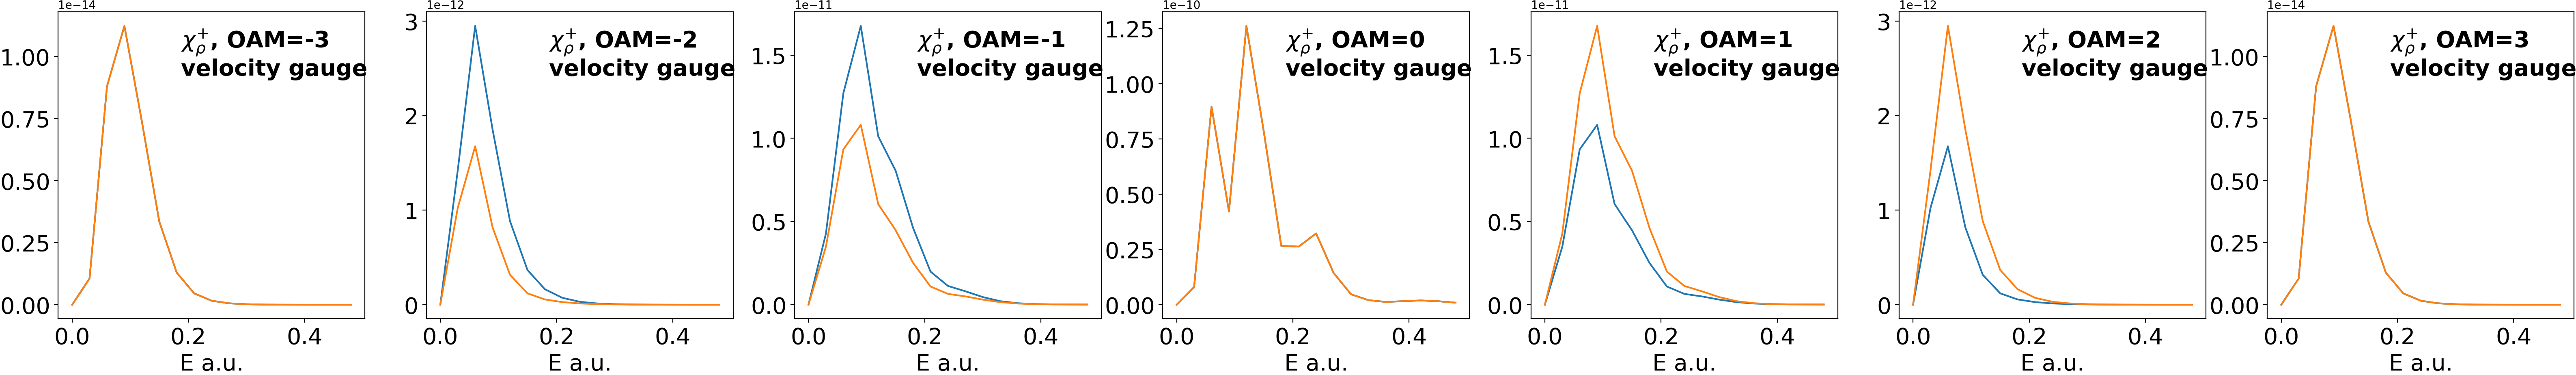

In [15]:
plt.figure(num=None, figsize=(40, 5), dpi=200, facecolor='w', edgecolor='k')
plt.tight_layout()
plt.autoscale(tight=True)

for j in range(0,7):
    ax = plt.subplot(1,7, j+1)
    ax.plot(EList,MintList1[j])
    ax.plot(EList,MintList2[j])
    ax.set_xlabel("E a.u.", fontsize=20)
    #ax.set_ylabel("Signal arb.", fontsize=20)
    ax.tick_params(labelsize=20)
    ax.text(0.4, 0.95, r"$\chi_{\rho}^{+}$, OAM="+str(OAMList[j]), transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', color ='black')
    ax.text(0.4, 0.85, "velocity gauge", transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', color ='black')

#fig.tight_layout()
#plt.savefig("X:\PHOTONICS\TFM\integration2.jpg")

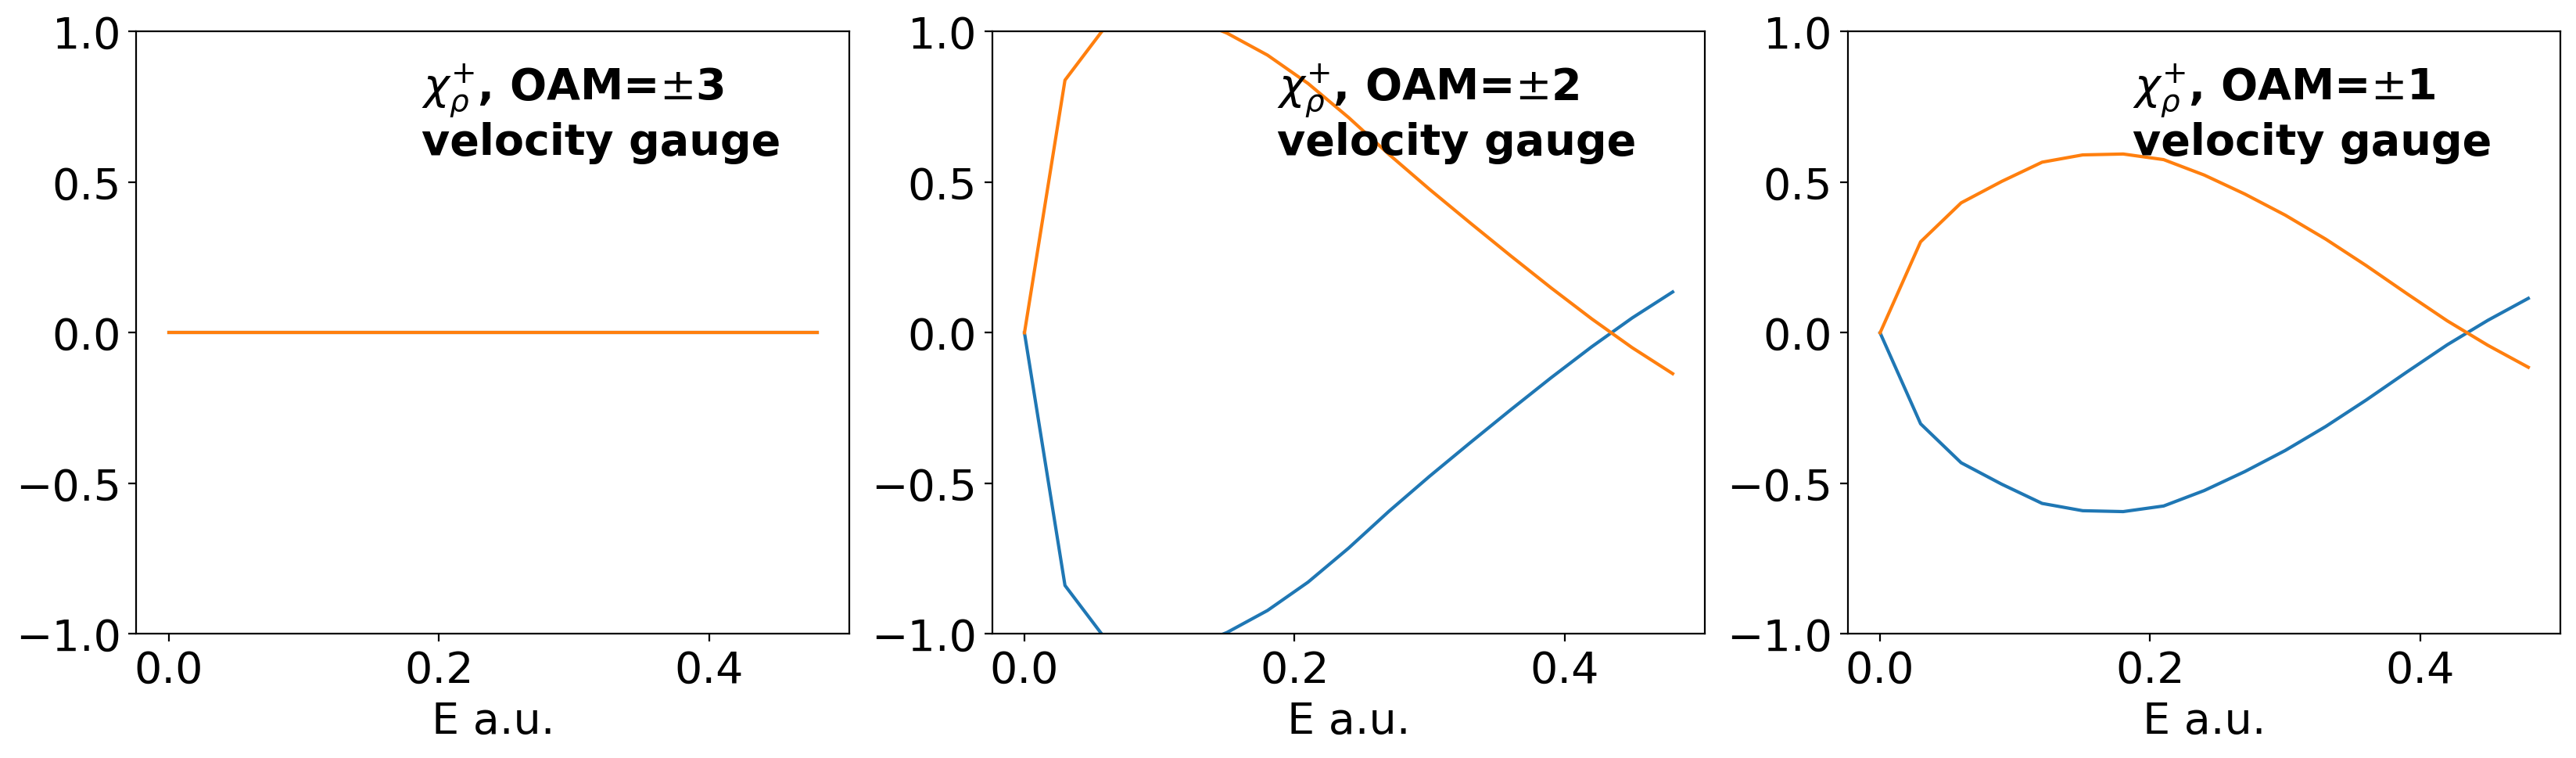

In [23]:
plt.figure(num=None, figsize=(20, 5), dpi=200, facecolor='w', edgecolor='k')
plt.tight_layout()
plt.autoscale(tight=True)

OAMList2=[3,2,1]

i=6
for j in range(3):
    ax = plt.subplot(1,3, j+1)

    ax.plot(EList,2*(MintList1[j]-MintList1[i])/(MintList1[j]+MintList1[i]+1e-32))
    ax.plot(EList,2*(MintList2[j]-MintList2[i])/(MintList2[j]+MintList2[i]+1e-32))
    ax.set_ylim([-1,1])
    ax.set_xlabel("E a.u.", fontsize=20)
    #ax.set_ylabel("Signal arb.", fontsize=20)
    ax.tick_params(labelsize=20)
    ax.text(0.4, 0.95, r"$\chi_{\rho}^{+}$, OAM=$\pm$"+str(OAMList2[j]), transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', color ='black')
    ax.text(0.4, 0.85, "velocity gauge", transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', color ='black')
    i=i-1
    
#plt.tight_layout()
#plt.savefig("X:\PHOTONICS\TFM\integration_diff2.jpg")

# Figure paper data

In [8]:
#Make class instance
omegaIn = 0.057
IpIn = 0.579
UpIn = 0.44
NIn = 2
CEPIn = [0, Pi/2, Pi, 3*Pi/2]
ts = Pi/omegaIn + I* Pi/(2*omegaIn)
alpha=0.

#Velocity gauge: Gauge=0 \\ Length gauge: Gauge=1
Gauge=0

enant=0
nIn=[4,4,4,4]
lIn=[2,3,2,3]
mIn=[1,1,-1,-1]
constIn=[1,1j,-1,1j]

#make SFA pulse instance
SP = np.array([SFA_Lin.SFALinearPulse(IpIn, UpIn, omegaIn, NIn, nIn, lIn, mIn, constIn, CEPi, Gauge, alpha) 
               for CEPi in CEPIn])
NPulses = len(SP)

In [9]:
# OAM + OAM residual difference distributions data
dp=0.01
pzList = np.arange(-1.7, 1.7, dp)
pxList = np.arange(0, 1., dp)
pzGrid, pxGrid = np.meshgrid(pzList, pxList)

In [10]:
# OAM + OAM residual difference distributions data
OAMList=[-1,1]
MGrids_align_CEP = np.array([[pool.starmap(SP[i].aligned_av_list, zip(pxGrid, pzGrid, repeat(OAM), repeat(enant)) ) 
                     for OAM in OAMList] for i in range(0, NPulses)])
OAMList=[-2,2,1]
MGrids_oriAv_CEP = np.array([[pool.starmap(SP[i].orientation_av_list, zip(pxGrid, pzGrid, repeat(OAM), repeat(enant)) ) 
                     for OAM in OAMList] for i in range(0, NPulses)])

#CEP averaging
MGrids_align = np.sum(MGrids_align_CEP, 0)/NPulses
MGrids_oriAv = np.sum(MGrids_oriAv_CEP, 0)/NPulses

In [11]:
#insets data
M_align_diff = 2*(-MGrids_align[1]+MGrids_align[0])/(MGrids_align[1]+MGrids_align[0]+1e-32)
M_oriAv_diff = 2*(-MGrids_oriAv[1]+MGrids_oriAv[0])/(MGrids_oriAv[1]+MGrids_oriAv[0]+1e-32)

Fig2InsetData = [[MGrids_align[1], MGrids_oriAv[2]], [M_align_diff, M_oriAv_diff]]

In [12]:
# upper hemisphere integrals
ELim = 0.5 #velocity gauge
#ELim = 1. #length gauge
dE = 0.002
EList = np.arange(0, ELim, dE)

In [13]:
# upper hemisphere integrals

OAMList = [-2,-1,0,1,2]
Mint_align_CEP = np.array([[pool.starmap(SP[i].M_integration_align, zip(EList, repeat(0.), repeat(Pi/6), repeat(OAM), repeat(1.0e-02), repeat(500), repeat(enant) )) 
                       for OAM in OAMList] for i in range(0, NPulses)])
OAMList = [-2,-1,0,1,2]
Mint_oriAv_CEP = np.array([[pool.starmap(SP[i].M_integration_av, zip(EList, repeat(0.), repeat(Pi/6), repeat(OAM), repeat(1.0e-02), repeat(500), repeat(enant) )) 
                       for OAM in OAMList] for i in range(0, NPulses)])

#CEP averaging
Mint_align = np.sum(Mint_align_CEP, 0)/NPulses
Mint_oriAv = np.sum(Mint_oriAv_CEP, 0)/NPulses

In [14]:
#subplots data
Mint_align_diff1 = 2*(-Mint_align[4]+Mint_align[0])/(Mint_align[4]+Mint_align[0]+1e-32)
Mint_align_diff2 = 2*(-Mint_align[3]+Mint_align[1])/(Mint_align[3]+Mint_align[1]+1e-32)
Mint_align_diff3 = -Mint_align_diff1
Mint_align_diff4 = -Mint_align_diff2
Mint_align_diff = [Mint_align_diff1, Mint_align_diff2, Mint_align_diff3, Mint_align_diff4]

Mint_oriAv_diff1 = 2*(-Mint_oriAv[4]+Mint_oriAv[0])/(Mint_oriAv[4]+Mint_oriAv[0]+1e-32)
Mint_oriAv_diff2 = 2*(-Mint_oriAv[3]+Mint_oriAv[1])/(Mint_oriAv[3]+Mint_oriAv[1]+1e-32)
Mint_oriAv_diff3 = -Mint_oriAv_diff1
Mint_oriAv_diff4 = -Mint_oriAv_diff2
Mint_oriAv_diff = [Mint_oriAv_diff1, Mint_oriAv_diff2, Mint_oriAv_diff3, Mint_oriAv_diff4]

#Mint_oriAv[3]=np.zeros(len(Mint_oriAv[0]))

Fig2Data = [[Mint_align, Mint_oriAv], [Mint_align_diff, Mint_oriAv_diff]]

In [15]:
#save/load data:

#saveDataDump('Fig_Paper_Length', [Fig2InsetData, Fig2Data], DumpFileName)
#[Fig2InsetData, Fig2Data] = loadDataDump('Fig_Paper_Gauge', DumpFileName)

# Figure paper

In [9]:
[Fig2InsetData_2, Fig2Data_2] = loadDataDump('Fig_Paper_Velocity', DumpFileName)

dp=0.01
pzList = np.arange(-1.7, 1.7, dp)
pxList = np.arange(0, 1., dp)
pzGrid, pxGrid = np.meshgrid(pzList, pxList)

ELim = 0.5 #velocity gauge
#ELim = 1. #length gauge
dE = 0.002
EList = np.arange(0, ELim, dE)

In [10]:
# factors 10

#velocity gauge: factors 10 and 1000
#length gauge: factors 100 and 100000

#OAM = +-1
Fig2Data_2[0][1][1] = 10*Fig2Data_2[0][1][1]
Fig2Data_2[0][1][3] = 10*Fig2Data_2[0][1][3]

#OAM = +-2
Fig2Data_2[0][1][0] = 1000*Fig2Data_2[0][1][0]
Fig2Data_2[0][1][4] = 1000*Fig2Data_2[0][1][4]

In [11]:
Fig2Data = [[Fig2Data_2[0][0],Fig2InsetData_2[0][0],Fig2Data_2[0][1],Fig2InsetData_2[0][1]],
            [Fig2Data_2[1][0],Fig2InsetData_2[1][0],Fig2Data_2[1][1],Fig2InsetData_2[1][1]]]

Fig2DataDiff = [[np.diff(Fig2DataCol) for Fig2DataCol in Fig2DataRow] for Fig2DataRow in Fig2Data]

In [12]:
vals=[[1e-1, 1, 1e-1, 1], [1e-1, 1, 1e-1, 2]]
FigsDiffMask = [[[np.append(np.abs(ZQ)<val,True)  for ZQ in Fig2DataCol] for Fig2DataCol, val in zip(Fig2DataRow, valRow)] for Fig2DataRow, valRow in zip(Fig2DataDiff, vals)]

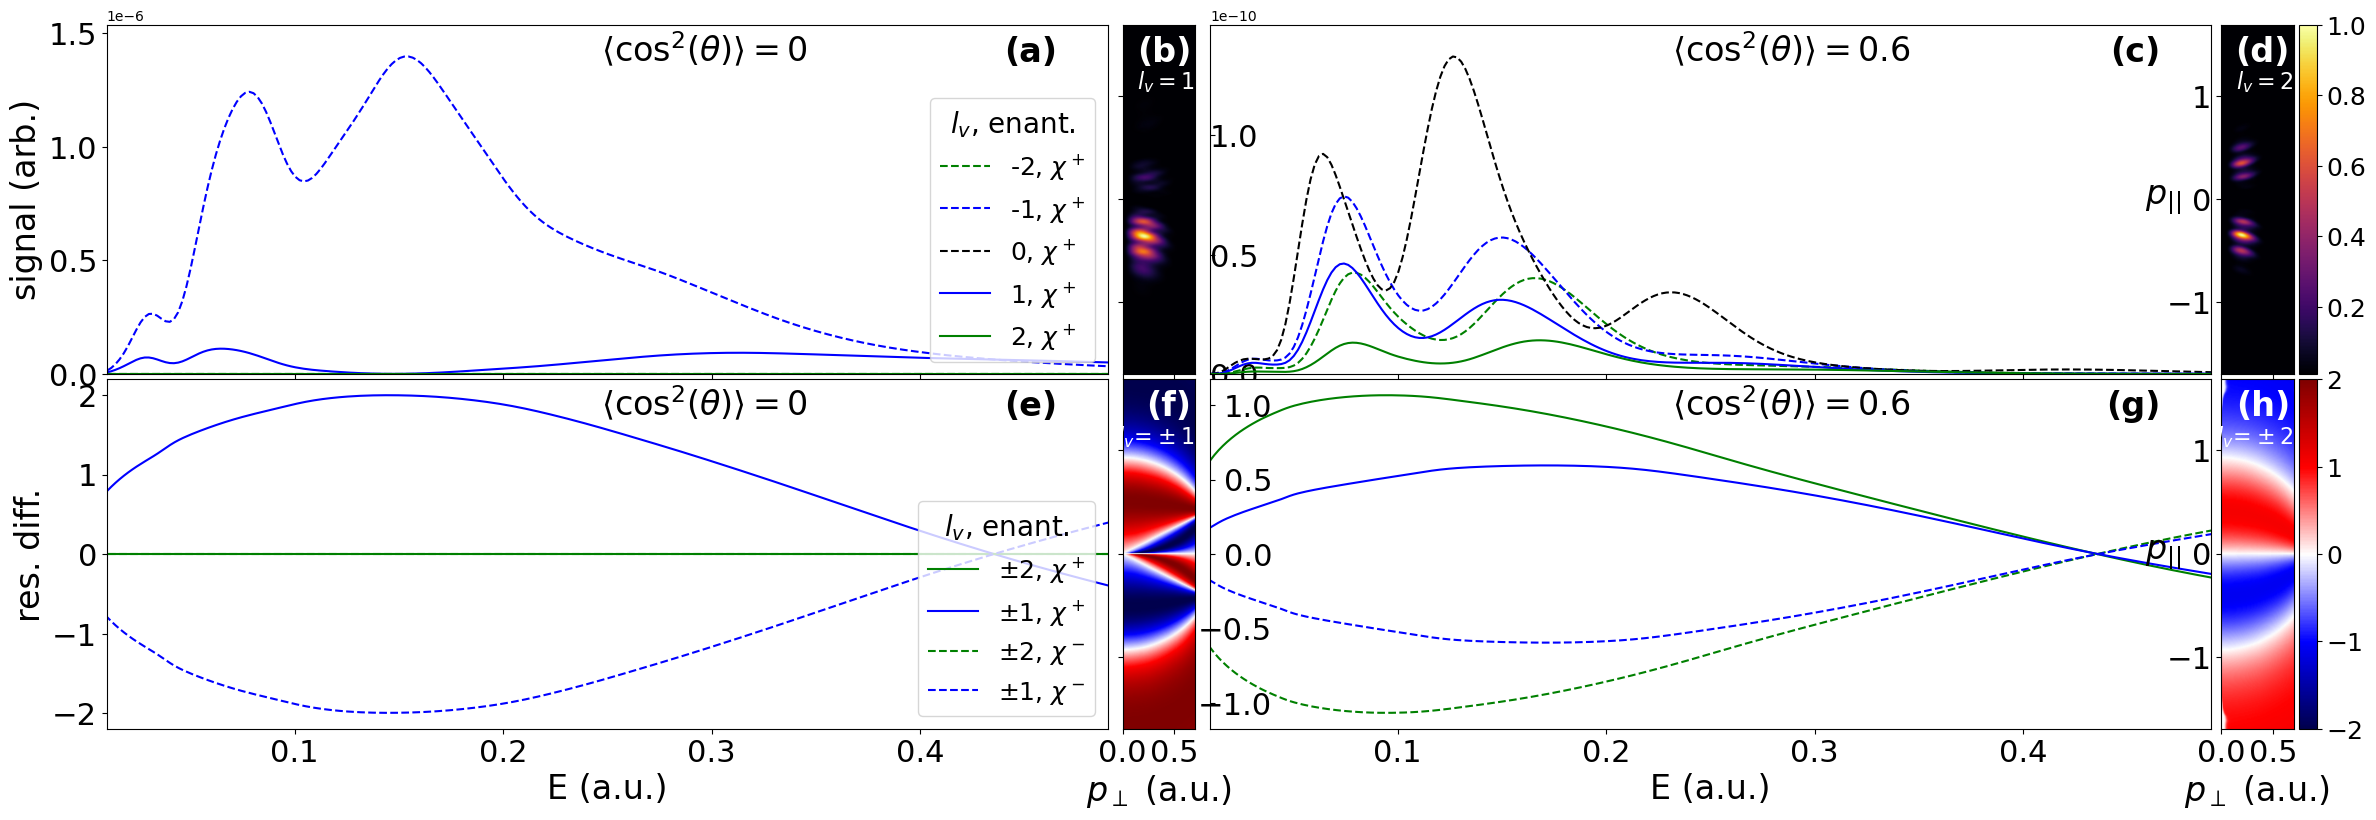

In [13]:
mLabGrid=[[str(m)+', $\chi^+$' for m in range(-2,2+1)]
      ,np.array([['$\pm$'+str(m)+pm for m in range(2,0,-1)] for pm in [', $\chi^+$', ', $\chi^-$']]).flatten()
         ]
colours= ['k', 'b', 'g', 'r', 'm']
mStyleGrid=[[colours[abs(m)]+'-'if m>0 else colours[abs(m)]+'--' for m in range(-2,2+1)]
      ,np.array([[colours[abs(m)]+'-' if pm else colours[abs(m)]+'--' for m in range(2,0,-1)] for pm in [True, False]]).flatten()
         ]
NQP = len(Fig2Data[0])
NQPLine = len(Fig2Data)
plt.style.use('default')
i=-1
fig, ax = plt.subplots(NQPLine, NQP, figsize=(6*NQP,4*NQPLine),gridspec_kw={'width_ratios': [10, 1, 10, 1.15]})
for ZQLine, MaskRow, axi, mList, mStyleLine in zip(Fig2Data, FigsDiffMask, ax, mLabGrid, mStyleGrid):
    for ZQs, MaskCol, axij in zip(ZQLine, MaskRow, axi):
        i=i+1
        #QMaxs= ZQs.max()
        QMaxs = np.amax(ZQs)
        if(i%2==0):
            for ZQ, Mask, mLab, mStyle in zip(ZQs, MaskCol, mList, mStyleLine):
                numb = len(ZQ[Mask])
                EList = np.linspace(0,ELim,numb)
                axij.plot(EList, ZQ[Mask], mStyle, label=mLab)
                if i<4:    
                    axij.set_ylim(0,QMaxs*1.1)
            axij.set_xlim(0.01,ELim-0.01)
                
            if(i<4):
                axij.set_xticklabels([])
                
            if(i==0 or i==4):
                leg = axij.legend(title="$l_v$, enant."
                                  #, bbox_to_anchor=(0.99,0.7)
                                  , loc="lower right",fontsize=18)
                leg.get_title().set_fontsize(20)
                axij.set_ylabel('signal (arb.)' if i==0 else 'res. diff.',fontsize=24)
                axij.text(0.7, 0.875, '$\langle \cos^2(\\theta)  \\rangle =0  $'
                        ,verticalalignment='bottom', horizontalalignment='right'
                        ,transform=axij.transAxes
                        ,weight='heavy'
                        ,color='black', fontsize=24)
            
            else:
                axij.text(0.97, 0.45, '$p_{||}$'
                            ,verticalalignment='bottom', horizontalalignment='right'
                            ,transform=axij.transAxes
                            ,weight='heavy'
                            ,color='black', fontsize=24)
                axij.text(0.7, 0.875, '$\langle \cos^2(\\theta)  \\rangle =0.6  $'
                        ,verticalalignment='bottom', horizontalalignment='right'
                        ,transform=axij.transAxes
                        ,weight='heavy'
                        ,color='black', fontsize=24)
                
            axij.set_xlabel('E (a.u.)',fontsize=24)
        else:
            axij.text(1.0, 0.8, ['$l_v=1$','$l_v=2$','$l_v\!=\!\pm1$','$l_v\!=\!\pm2$'][int((i-1)/2)]
                ,verticalalignment='bottom', horizontalalignment='right'
                ,transform=axij.transAxes
                ,weight='heavy'
                ,color='white', fontsize=16)
            if(i<4):
                mesh = axij.pcolormesh(pxGrid, pzGrid, ZQs/(QMaxs), cmap=cm.inferno
                            #,norm=LogNorm(vmin=QMaxInset*1e-4, vmax=QMaxInset*1e-2), rasterized=True, shading='gouraud')
                            ,vmin=0.01, vmax=1., rasterized=True, shading='gouraud')
                axij.set_xticklabels([])
            else:
                mesh = axij.pcolormesh(pxGrid, pzGrid, ZQs, cmap= cm.seismic 
                            , vmin=-2, vmax=2, rasterized=True, shading='gouraud')
            axij.set_xlim(0.00, 0.7)
            if i>3:
                axij.set_xlabel('$p_{\perp}$ (a.u.)',fontsize=24)
#             axij.text(0.9, 0.85, ['$l_v=1$','$l_v=1$','$l_v\!=\!\pm1$','$l_v\!=\!\pm2$'][i]
#                        ,verticalalignment='bottom', horizontalalignment='right'
#                         ,transform=axij2.transAxes
#                         ,weight='heavy'
#                         ,color='white' if i<2 else 'black', fontsize=14)
            axij.set_aspect('equal')
            if(i%4==3):
                cbar = fig.colorbar(mesh, ax=axij, fraction=0.24)
                cbar.ax.tick_params(labelsize=18) 
            else:
                axij.set_yticklabels([])
        
        

        axij.tick_params(axis='both', which='major', labelsize=22)
        axij.text(0.95, 0.875, ['(a)','(b)','(c)','(d)','(e)', '(f)', '(g)', '(h)'][i]
            ,verticalalignment='bottom', horizontalalignment='right'
            ,transform=axij.transAxes
            ,weight='heavy'
            ,color='black' if(i%2==0) else 'white', fontsize=24)
        
        if(i==2 or i==6):
            axij.tick_params(axis="y",direction="in", pad=-35 if(i==2) else -45)
        

fig.subplots_adjust(left=0.05, bottom=0.1, right=0.975, top=0.98, wspace=0.002, hspace=0.015)
#plt.savefig("X:\PHOTONICS\TFM\Fig3.jpg", dpi=200, pad_inches = 0.)

# Figure paper both gauges

In [14]:
[Fig2InsetData_v, Fig2Data_v] = loadDataDump('Fig_Paper_Velocity', DumpFileName)
[Fig2InsetData_l, Fig2Data_l] = loadDataDump('Fig_Paper_Length', DumpFileName)

dp=0.01
pzList = np.arange(-1.7, 1.7, dp)
pxList = np.arange(0, 1., dp)
pzGrid, pxGrid = np.meshgrid(pzList, pxList)

In [33]:
Fig2Data = [[Fig2Data_v[0][0],Fig2InsetData_v[0][0],Fig2Data_l[0][0],Fig2InsetData_l[0][0]],
            [Fig2Data_v[1][0],Fig2InsetData_v[1][0],Fig2Data_l[1][0],Fig2InsetData_l[1][0]]]

Fig2Data_v1 = [Fig2Data_v[0][0][1],Fig2Data_v[0][0][3]]
Fig2Data_l1 = [Fig2Data_l[0][0][1],Fig2Data_l[0][0][3]]

Fig2Data_v2 = [Fig2Data_v[1][0][1],Fig2Data_v[1][0][3]]
Fig2Data_l2 = [Fig2Data_l[1][0][1],Fig2Data_l[1][0][3]]

Fig2Data = [[Fig2Data_v1,Fig2InsetData_v[0][0],Fig2Data_l1,Fig2InsetData_l[0][0]],
            [Fig2Data_v2,Fig2InsetData_v[1][0],Fig2Data_l2,Fig2InsetData_l[1][0]]]

Fig2DataDiff = [[np.diff(Fig2DataCol) for Fig2DataCol in Fig2DataRow] for Fig2DataRow in Fig2Data]

In [34]:
vals=[[1e-1, 1, 1e-1, 1], [1e-1, 1, 1e-1, 2]]
FigsDiffMask = [[[np.append(np.abs(ZQ)<val,True)  for ZQ in Fig2DataCol] for Fig2DataCol, val in zip(Fig2DataRow, valRow)] for Fig2DataRow, valRow in zip(Fig2DataDiff, vals)]

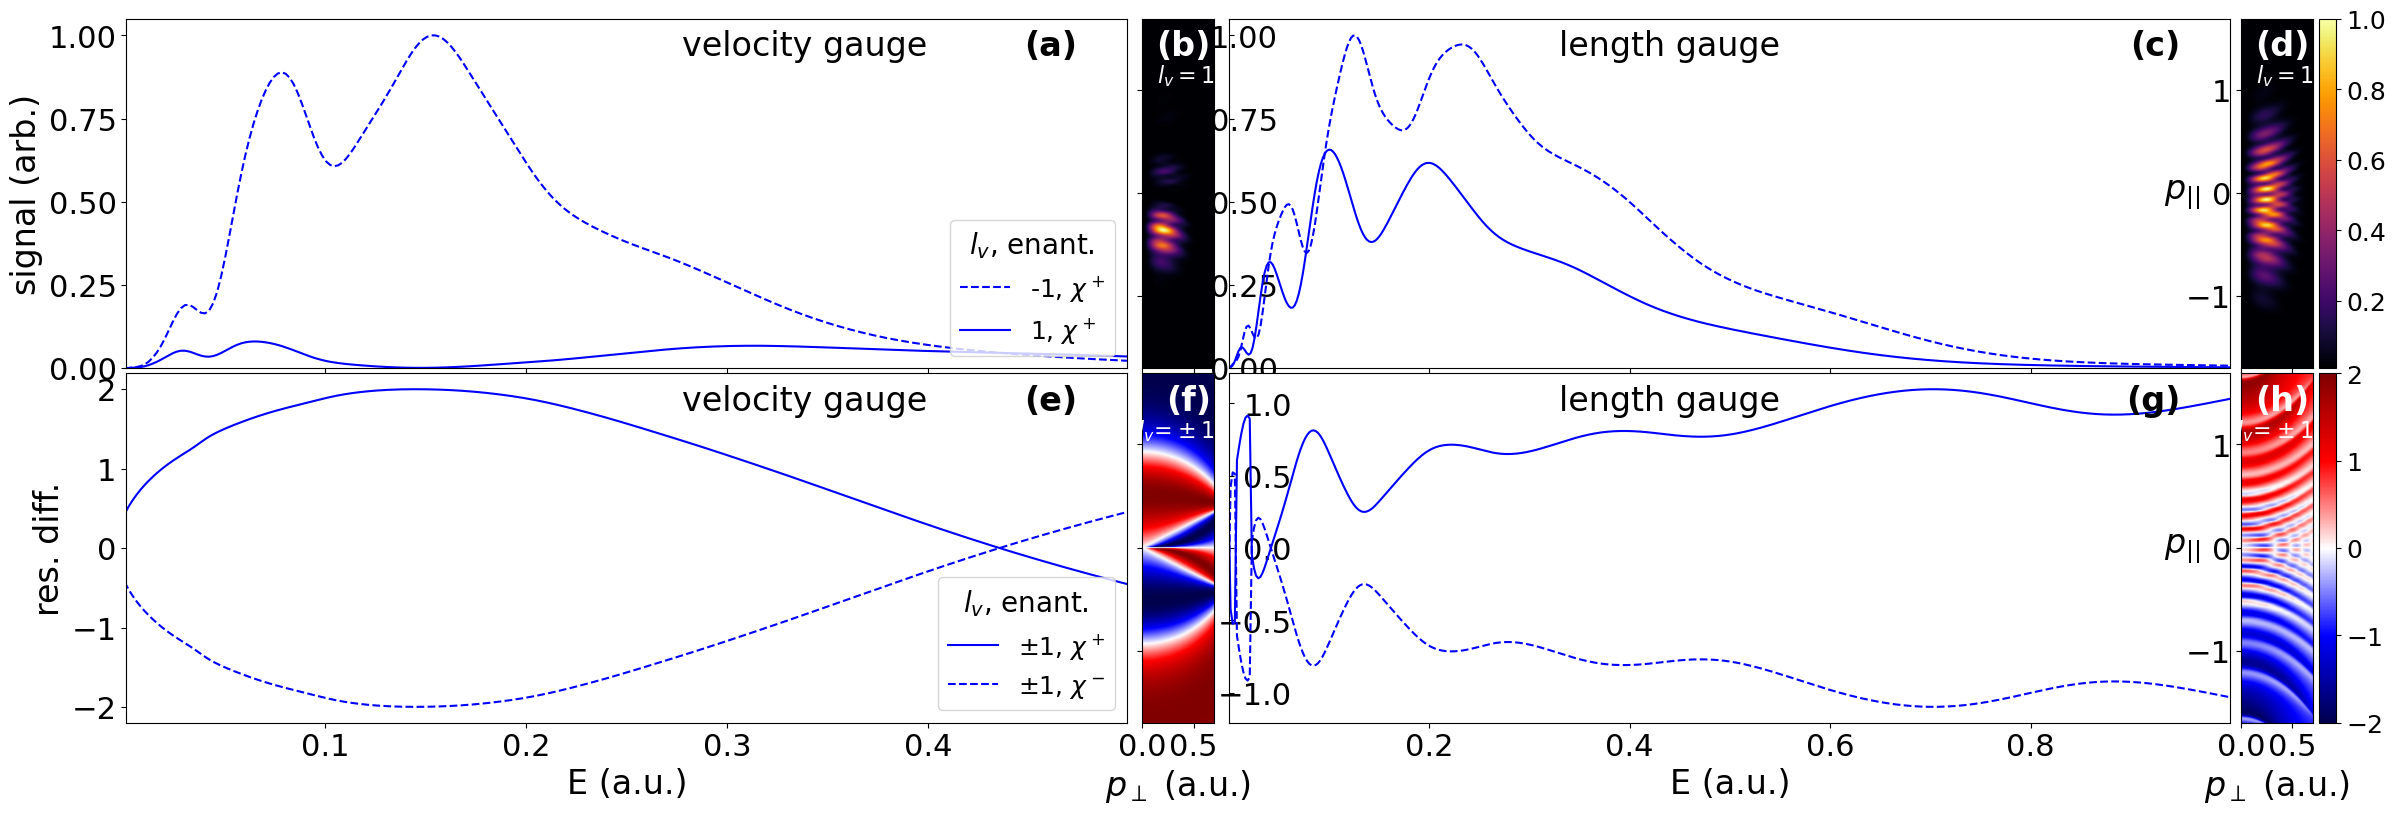

In [103]:
#mLabGrid=[[str(m)+', $\chi^+$' for m in [-1,1]]
#      ,np.array([['$\pm$'+str(m)+pm for m in range(2,0,-1)] for pm in [', $\chi^+$', ', $\chi^-$']]).flatten()]
mLabGrid=[[str(m)+', $\chi^+$' for m in [-1,1]]
      ,np.array(['$\pm$'+str(1)+pm  for pm in [', $\chi^+$', ', $\chi^-$']]).flatten()]
         
#colours= ['k','b', 'g', 'r', 'm']
colours = ['b','b','b','b','b']
#mStyleGrid=[[colours[abs(m)]+'-'if m>0 else colours[abs(m)]+'--' for m in range(-2,2+1)]
#      ,np.array([[colours[abs(m)]+'-' if pm else colours[abs(m)]+'--' for m in range(2,0,-1)] for pm in [True, False]]).flatten()]
mStyleGrid=[[colours[abs(m)]+'-'if m>0 else colours[abs(m)]+'--' for m in [-1,1]]
      ,np.array([colours[abs(m)]+'-' if m<0 else colours[abs(m)]+'--' for m in [-1,1]])] 

NQP = len(Fig2Data[0])
NQPLine = len(Fig2Data)
plt.style.use('default')
i=-1
fig, ax = plt.subplots(NQPLine, NQP, figsize=(6*NQP,4*NQPLine),gridspec_kw={'width_ratios': [10, 1, 10, 1.15]})
for ZQLine, MaskRow, axi, mList, mStyleLine in zip(Fig2Data, FigsDiffMask, ax, mLabGrid, mStyleGrid):
    for ZQs, MaskCol, axij in zip(ZQLine, MaskRow, axi):
        i=i+1
        #QMaxs= ZQs.max()
        QMaxs = np.amax(ZQs)
        if(i%2==0):
            for ZQ, Mask, mLab, mStyle in zip(ZQs, MaskCol, mList, mStyleLine):
                numb = len(ZQ[Mask])
                ELim = 0.5 if (i==0 or i==4) else 1.
                EList = np.linspace(0,ELim,numb)
                if i<4:
                    axij.plot(EList, ZQ[Mask]/QMaxs, mStyle, label=mLab)
                    axij.set_ylim(bottom=0)
                else:
                    axij.plot(EList, ZQ[Mask], mStyle, label=mLab)

            axij.set_xlim(0.001,ELim-0.001)
                
            if(i<4):
                axij.set_xticklabels([])
                
            if(i==0 or i==4):
                leg = axij.legend(title="$l_v$, enant."
                                  #, bbox_to_anchor=(0.99,0.7)
                                  , loc="lower right",fontsize=18)
                leg.get_title().set_fontsize(20)
                axij.set_ylabel('signal (arb.)' if i==0 else 'res. diff.',fontsize=24)
                axij.text(0.8, 0.875, 'velocity gauge'
                        ,verticalalignment='bottom', horizontalalignment='right'
                        ,transform=axij.transAxes
                        ,weight='normal'
                        ,color='black', fontsize=24)
            
            else:
                axij.text(0.97, 0.45, '$p_{||}$'
                            ,verticalalignment='bottom', horizontalalignment='right'
                            ,transform=axij.transAxes
                            ,weight='heavy'
                            ,color='black', fontsize=24)
                axij.text(0.55, 0.875, 'length gauge'
                        ,verticalalignment='bottom', horizontalalignment='right'
                        ,transform=axij.transAxes
                        ,weight='normal'
                        ,color='black', fontsize=24)
                
            axij.set_xlabel('E (a.u.)',fontsize=24)
        else:
            axij.text(1.0, 0.8, ['$l_v=1$','$l_v=1$','$l_v\!=\!\pm1$','$l_v\!=\!\pm1$'][int((i-1)/2)]
                ,verticalalignment='bottom', horizontalalignment='right'
                ,transform=axij.transAxes
                ,weight='heavy'
                ,color='white', fontsize=16)
            if(i<4):
                mesh = axij.pcolormesh(pxGrid, pzGrid, ZQs/(QMaxs), cmap=cm.inferno
                            #,norm=LogNorm(vmin=QMaxInset*1e-4, vmax=QMaxInset*1e-2), rasterized=True, shading='gouraud')
                            ,vmin=0.01, vmax=1., rasterized=True, shading='gouraud')
                axij.set_xticklabels([])
            else:
                mesh = axij.pcolormesh(pxGrid, pzGrid, ZQs, cmap= cm.seismic 
                            , vmin=-2, vmax=2, rasterized=True, shading='gouraud')
            axij.set_xlim(0.00, 0.7)
            if i>3:
                axij.set_xlabel('$p_{\perp}$ (a.u.)',fontsize=24)
#             axij.text(0.9, 0.85, ['$l_v=1$','$l_v=1$','$l_v\!=\!\pm1$','$l_v\!=\!\pm2$'][i]
#                        ,verticalalignment='bottom', horizontalalignment='right'
#                         ,transform=axij2.transAxes
#                         ,weight='heavy'
#                         ,color='white' if i<2 else 'black', fontsize=14)
            axij.set_aspect('equal')
            if(i%4==3):
                cbar = fig.colorbar(mesh, ax=axij, fraction=0.24)
                cbar.ax.tick_params(labelsize=18) 
            else:
                axij.set_yticklabels([])
        
        

        axij.tick_params(axis='both', which='major', labelsize=22)
        axij.text(0.95, 0.875, ['(a)','(b)','(c)','(d)','(e)', '(f)', '(g)', '(h)'][i]
            ,verticalalignment='bottom', horizontalalignment='right'
            ,transform=axij.transAxes
            ,weight='heavy'
            ,color='black' if(i%2==0) else 'white', fontsize=24)
        
        if(i==2 or i==6):
            axij.tick_params(axis="y",direction="in", pad=-35 if(i==2) else -45)
        

fig.subplots_adjust(left=0.05, bottom=0.1, right=0.975, top=0.98, wspace=0.002, hspace=0.015)
plt.savefig("X:\PHOTONICS\TFM\Fig3.jpg", dpi=200, pad_inches = 0.)